In [13]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import decimate
from dsp import frame_start_correlations, frame_start_correlations_vect
from utils import plot_correlations, plot_signals, welch

# ADS-B signal decoding
Data source (noisy?): [Signal Identification Wiki](https://www.sigidwiki.com/wiki/Automatic_Dependent_Surveillance-Broadcast_(ADS-B))

Another data source: [SDR Angel](http://www.sdrangel.org/iq-files/)

My own recording: VJC967 flight arriving in Da Nang (to be tested later because of noise).

In [2]:
# sample_rate, iq_samples = wavfile.read('data/ADS-B SDRSharp_20150526_203031Z_1090000kHz_IQ.wav')
sample_rate, iq_samples = wavfile.read('data/adsb/adsb.2021-11-26T15_03_30_573.wav')

/tmp/ipykernel_101995/806377189.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, iq_samples = wavfile.read('data/adsb/adsb.2021-11-26T15_03_30_573.wav')


In [3]:
iq_samples = iq_samples[:, 0] + 1j * iq_samples[:, 1]

In [4]:
iq_samples.shape

(245010432,)

In [5]:
sample_rate

2400000

/home/jakub/projects/SDR/SDR/env/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:454: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


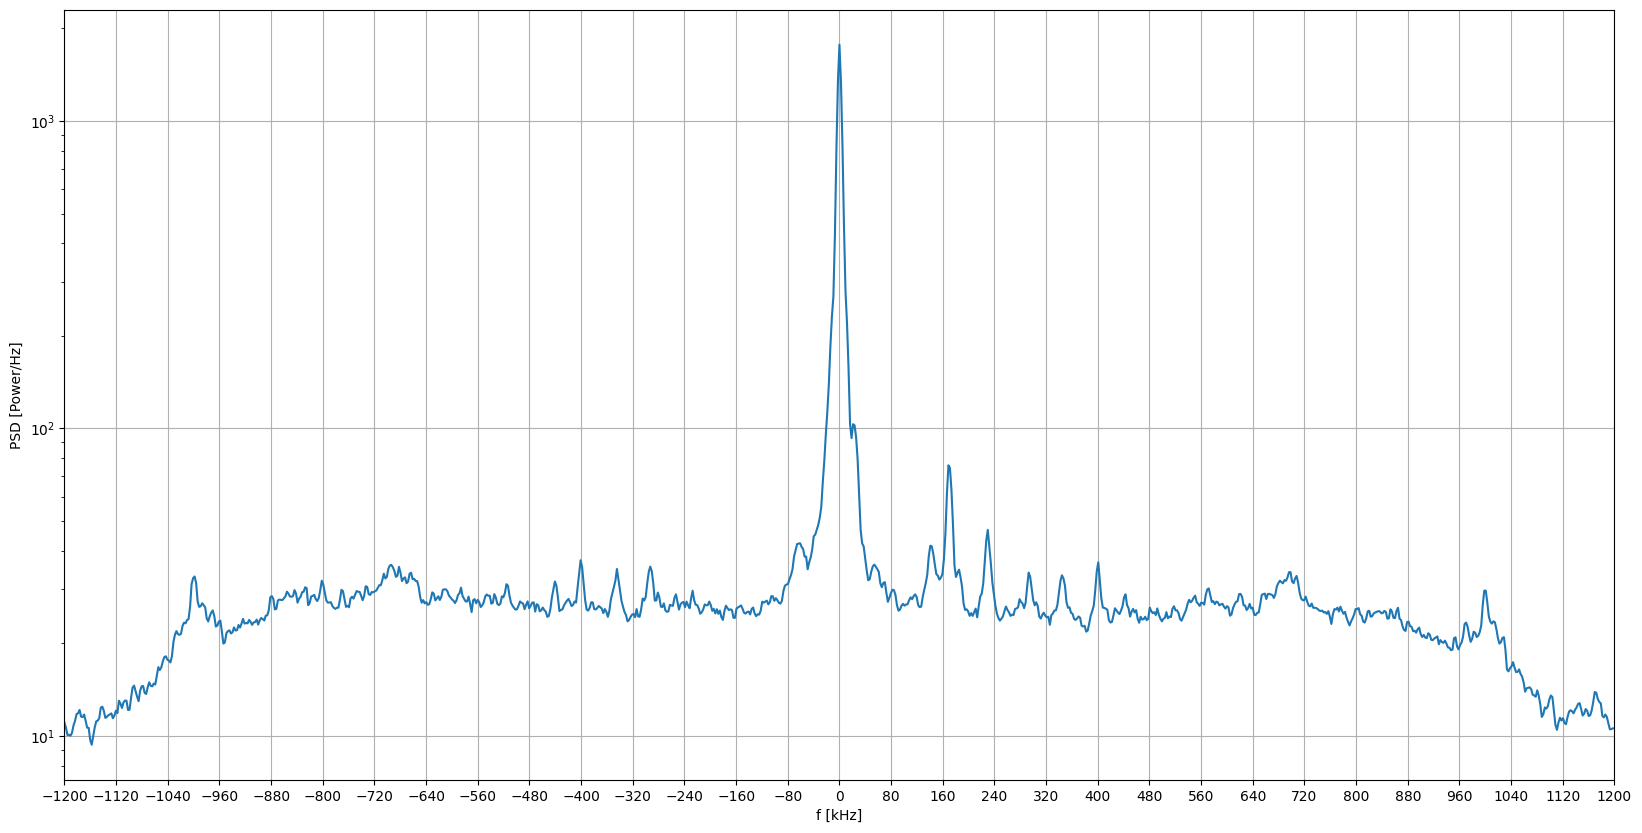

In [6]:
welch(iq_samples[:1_000_000], sample_rate)

In [7]:
pulse_duration_s = 0.5e-6
pulse_size_samples = pulse_duration_s * sample_rate

preamble_duration_s = 8e-6
preamble_size_samples = preamble_duration_s * sample_rate

data_frame_duration_s = 112e-6
frame_duration_s = preamble_duration_s + data_frame_duration_s
frame_size_samples = frame_duration_s * sample_rate

print(f'Single pulse consists of {pulse_size_samples} samples\nSingle frame contains {frame_size_samples} samples\nPreamble contains {preamble_size_samples} samples')

Single pulse consists of 1.2 samples
Single frame contains 288.0 samples
Preamble contains 19.2 samples


In [8]:
adsb_signal = np.abs(iq_samples)

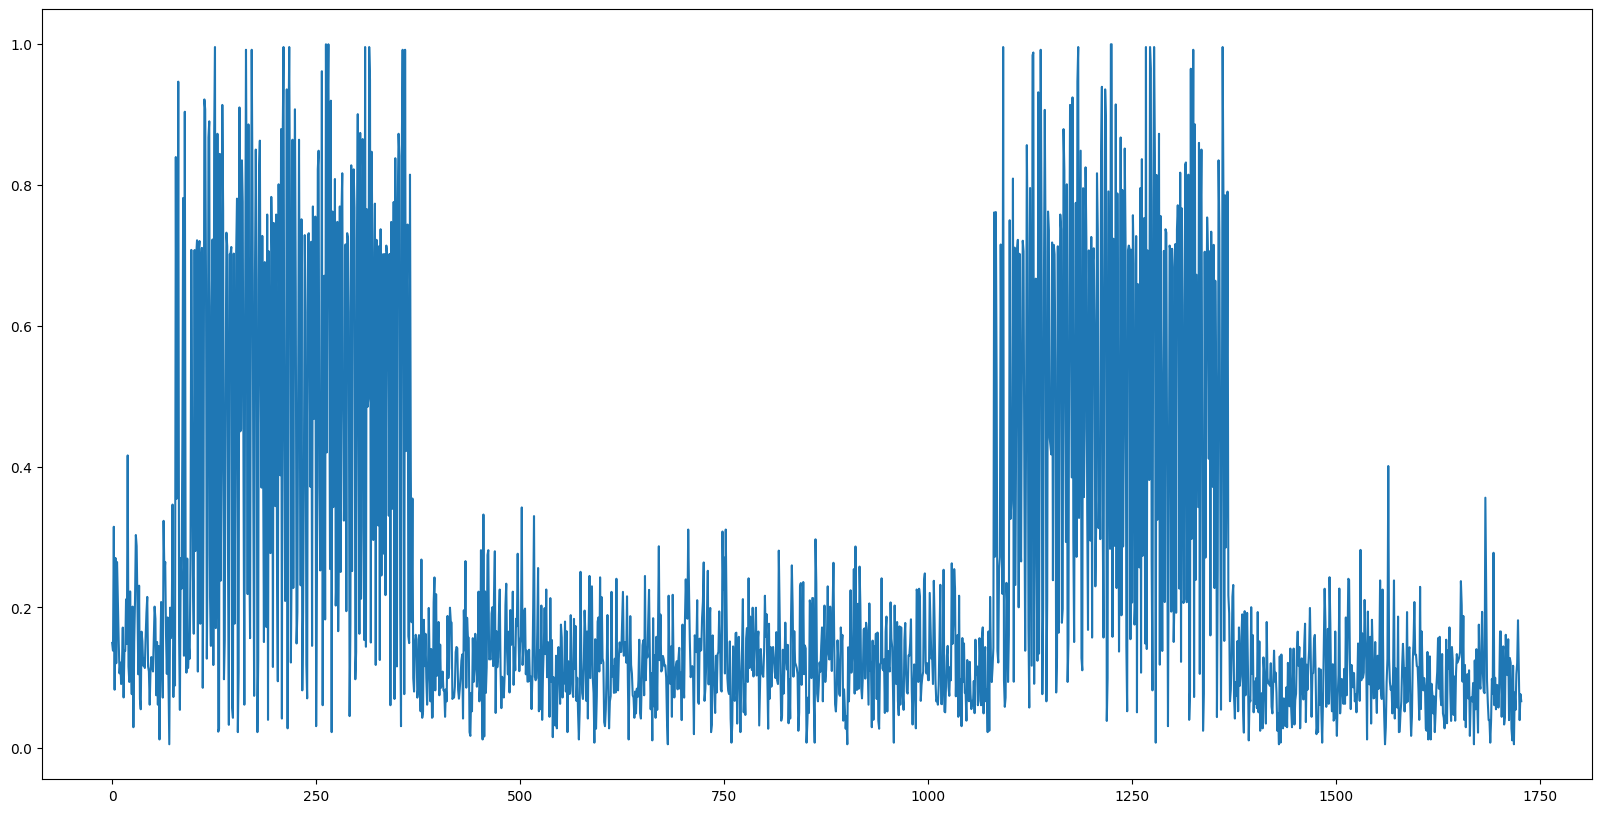

In [9]:
start, width = 42500, int(6 * frame_size_samples)
plot_signals([adsb_signal], start=start, width=width)

Looks reasonably clean, let's take a look at the preamble.

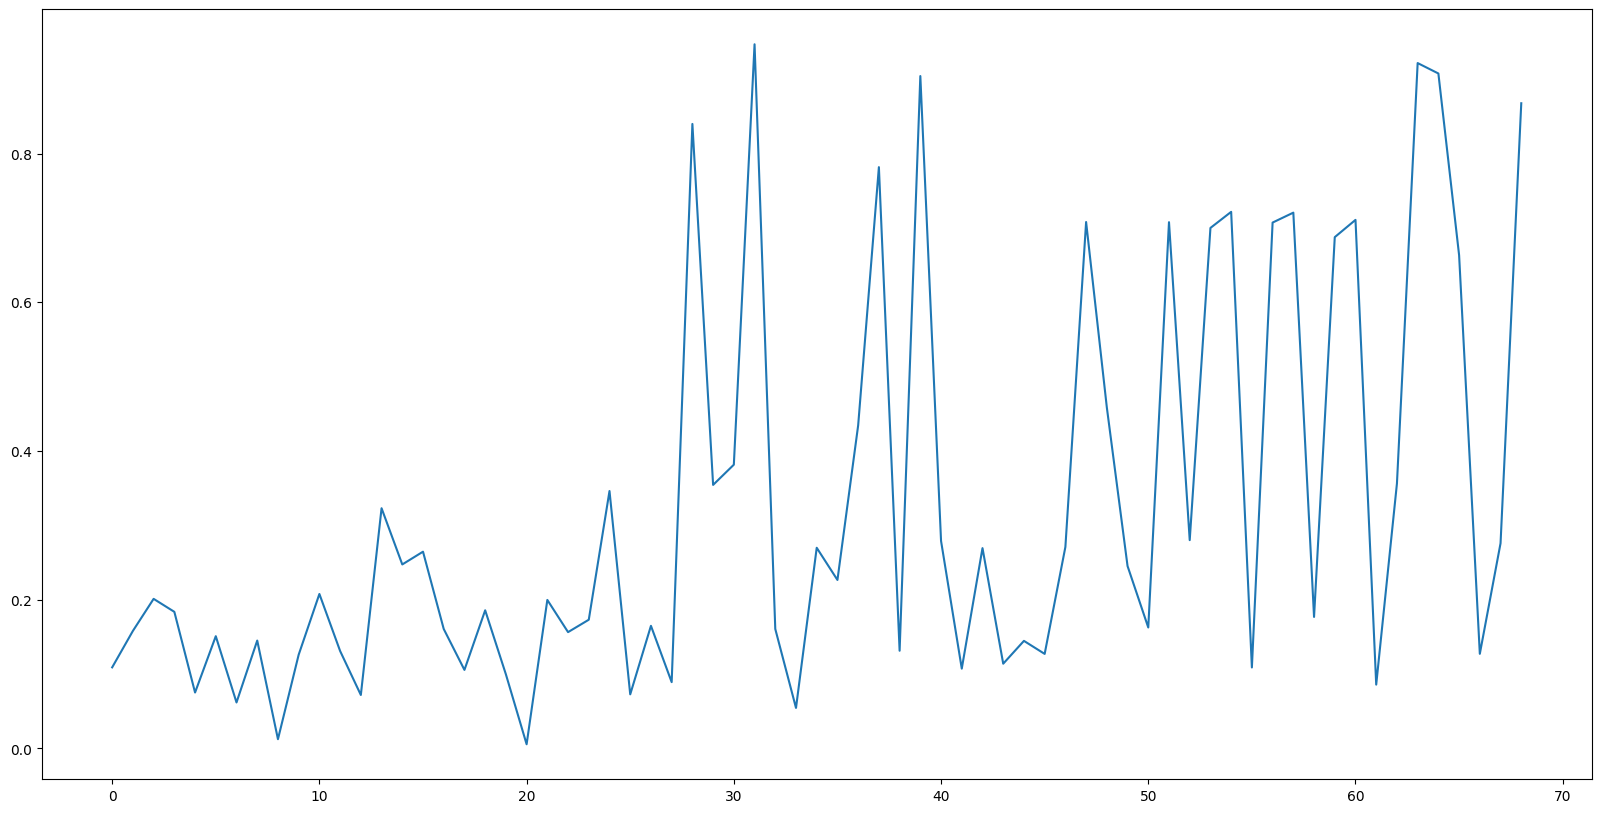

In [17]:
plot_signals([adsb_signal], start=start+50, width=int(50 + preamble_size_samples))

Looks good. Gotta mention that all other data I've tried was waaaay to noisy to see this pattern.

### Find frame beginnings
Data frame structure described [here](https://www.mathworks.com/help/supportpkg/usrpradio/ug/airplane-tracking-using-ads-b-signals-2.html).

In [15]:
preamble = np.array(list(map(lambda b: int(b), '1010000101000000')))
sub_correlations = frame_start_correlations(adsb_signal[start:start + width + int(6 * frame_size_samples)], preamble, pulse_size_samples)

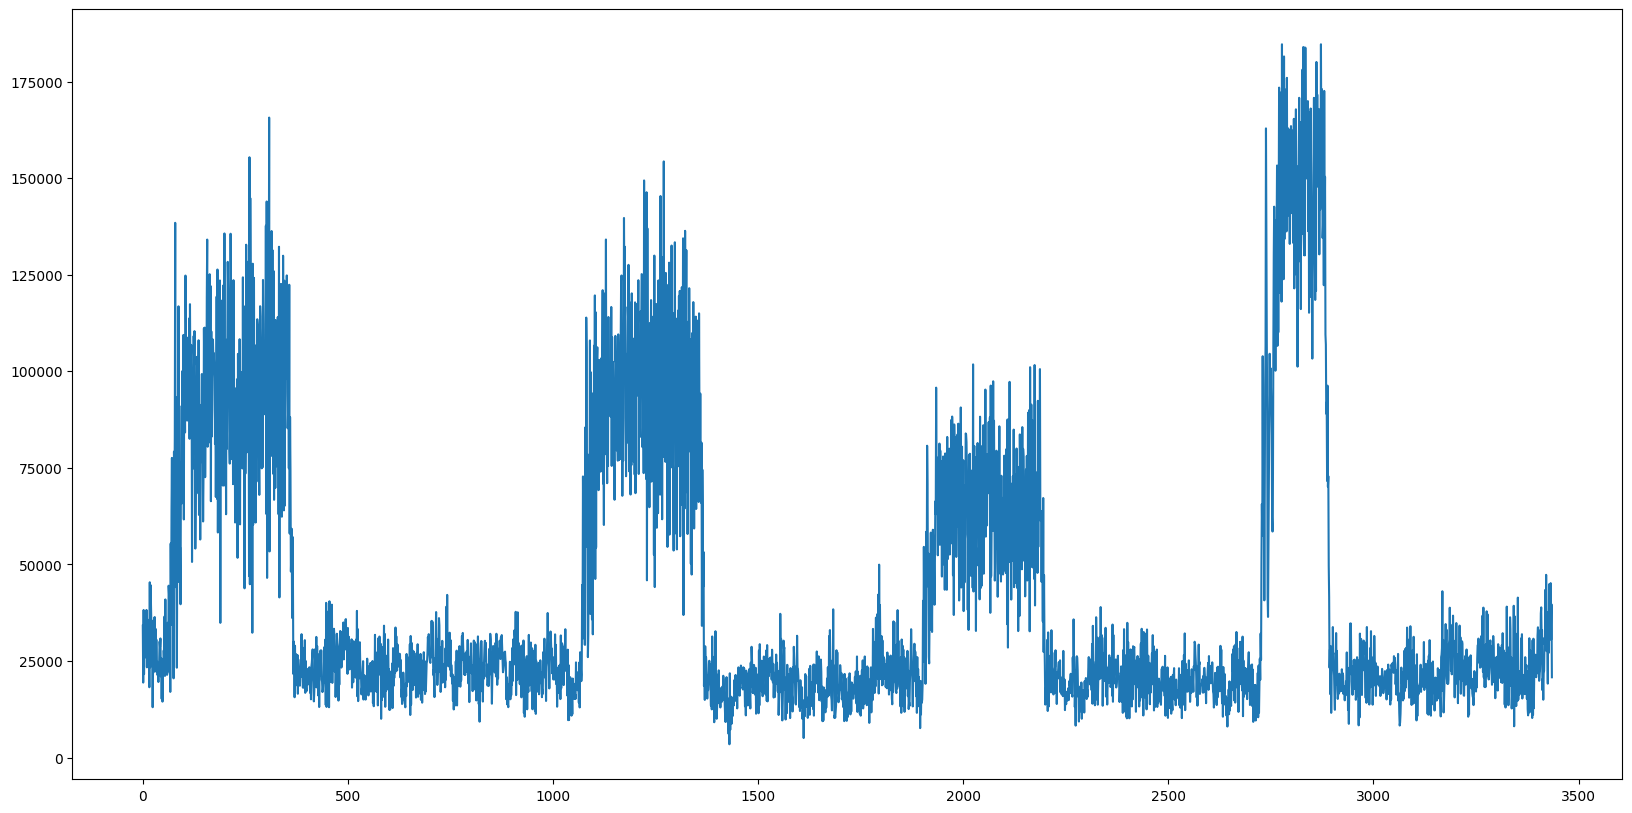

In [16]:
plot_correlations(sub_correlations)